# DataFix Demo

In [14]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from torch.distributions.multivariate_normal import MultivariateNormal
from datafix import DFLocate, DFCorrect

## Generate Dataset with Multivariate Gaussians

In [15]:
def _generate_mvg_dataset(
    n_samples, 
    loc1, 
    loc2, 
    scale_tril1, 
    scale_tril2, 
    cov1, 
    cov2, 
    n_corrupted, 
    transforms=None
):
    
    if scale_tril1 != None:
        p = MultivariateNormal(loc1, scale_tril=scale_tril1)
        q = MultivariateNormal(loc2, scale_tril=scale_tril2)
    else:
        p = MultivariateNormal(loc1, covariance_matrix=cov1)
        q = MultivariateNormal(loc2, covariance_matrix=cov2)
    
    if transforms != None:
        print('doing transforms', transforms)
        p = TransformedDistribution(p, transforms)
        q = TransformedDistribution(q, transforms)

    p_dset = p.sample((n_samples,)).numpy()
    q_dset = q.sample((n_samples,)).numpy()

    return p_dset, q_dset

def generate_mvg_dataset(
    n_dim, 
    n_corrupted, 
    n_samples, 
    mean_shift, 
    scale_shift, 
    shuffle_manipulation=None, 
    covariance_diagonal=True, 
    transforms=None, 
    p=2.0, 
    scale=10.0, 
    sequential=True
):

    loc1 = torch.zeros(n_dim)
    loc2 = torch.zeros(n_dim)
    loc2[0:n_corrupted] += mean_shift
       
    if not covariance_diagonal:
        cov1 = _get_cov_mat(n_dim, p=p, scale=scale, sequential=sequential)
        cov2 = cov1.clone()
        
        cov_shift = torch.zeros(n_dim)
        cov_shift[0:n_corrupted] += scale_shift
        cov2 = cov2 + torch.diag(cov_shift)
        
        scale1, scale2, scale_tril1, scale_tril2 = torch.zeros(1), torch.zeros(1), None, None
        
    else:
        scale1 = torch.ones(n_dim)
        scale2 = torch.ones(n_dim)
        scale2[0:n_corrupted] += scale_shift
        scale_tril1 = torch.diag(scale1)
        scale_tril2 = torch.diag(scale2)
        
        cov1, cov2 = None, None
    
    
    if shuffle_manipulation == 'feature-wise':
        for i in range(n_corrupted):
            cov2[i,(i+1):] = 0.0
            cov2[(i+1):,i] = 0.0
    elif shuffle_manipulation == 'sample-wise':
        for i in range(n_corrupted):
            cov2[i,n_corrupted:] = 0.0
            cov2[n_corrupted:,i] = 0.0
    
    
    p_dset, q_dset = _generate_mvg_dataset(
        n_samples, 
        loc1, 
        loc2, 
        scale_tril1, 
        scale_tril2, 
        cov1, 
        cov2, 
        n_corrupted, 
        transforms=transforms)

    dataset = {
        'ref':p_dset,'que':q_dset,
    }
    
    return dataset

To begin, we create the reference and query datasets for our analysis. These datasets are generated based on Multivariate Gaussians, using diagonal covariance and a shifted mean. Each dataset comprises 3000 samples and includes 100 features. In the query dataset, the **first 20 features** are **corrupted** by introducing a shift in the mean of 0.5.

In [16]:
n_dim = 100
n_corrupted = 20
shift = 0.5
n_samples = 3000

dataset = generate_mvg_dataset(
    n_dim, n_corrupted, n_samples, shift, 0.0, shuffle_manipulation=None, covariance_diagonal=True
)

reference = dataset['ref']
query = dataset['que']

## DFLocate

DataFix consists of two systems: ***DF-Locate***, which locates the features causing the distribution shift, and ***DF-Correct***, which modifies the query samples in order to decrease the distribution shift between the two datasets. Following, we create an instance of **DFLocate** with the specified input parameters. 

In [17]:
parameters = {
    "percentage" : 0.1,
    "step" : None,
    "alpha" : 1.0,
    "threshold" : None,
    "estimator" : RandomForestClassifier(random_state=0),
    "cv" : 5,
    "test_size" : None,
    "scoring" : 'balanced_accuracy',
    "n_jobs" : -1,
    "return_estimator" : False,
    "margin" : 0.01,
    "max_it" : None,
    "max_features_to_filter" : 0.5,
    "patience" : None,
    "random_state" : 0,
    "window_length" : 2,
    "polyorder" : 4,
    "S" : 5,
    "online" : False,
    "find_best" : 'knee-balanced',
    "verbose" : True
}

In [18]:
datafix_locate = DFLocate(**parameters)

### Shift Detection

The `shift_detection()` method can be used to identify if there is a distribution shift between a reference dataset and a query dataset. First, a discriminator is fit to distinguish between samples from the reference or the query. Then, the discriminator is evaluated on the test samples to determine if there is a divergence:

In [19]:
datafix_locate = datafix_locate.shift_detection(reference, query)

balanced_acc=0.8424999999999999


### Shift Location

The `shift_location()` method can be used to iteratively localize the corrupted features in the query that cause a distribution shift between the query and the reference datasets.

In [20]:
datafix_locate = datafix_locate.shift_location(reference, query)

iteration=1 | balanced_acc=0.8424999999999999 | corrupted_features=3
iteration=2 | balanced_acc=0.8146666666666667 | corrupted_features=2
iteration=3 | balanced_acc=0.7976666666666666 | corrupted_features=2
iteration=4 | balanced_acc=0.7831666666666667 | corrupted_features=2
iteration=5 | balanced_acc=0.7625 | corrupted_features=2
iteration=6 | balanced_acc=0.7316666666666667 | corrupted_features=2
iteration=7 | balanced_acc=0.7076666666666667 | corrupted_features=2
iteration=8 | balanced_acc=0.6798333333333334 | corrupted_features=1
iteration=9 | balanced_acc=0.6628333333333334 | corrupted_features=1
iteration=10 | balanced_acc=0.6398333333333333 | corrupted_features=1
iteration=11 | balanced_acc=0.6136666666666667 | corrupted_features=1
iteration=12 | balanced_acc=0.5826666666666667 | corrupted_features=1
iteration=13 | balanced_acc=0.5131666666666667 | corrupted_features=1
iteration=14 | balanced_acc=0.5046666666666667 | corrupted_features=1


### Plot Evolution

The ``plot_evolution()`` method can be used to plot the evolution curve of balanced accuracy and smoothed balanced accuracy versus the number of corrupted features removed. It can also plot the iteration or knee with the correct number of corrupted features. Additionally, the F1 score curve can be optionally plotted.

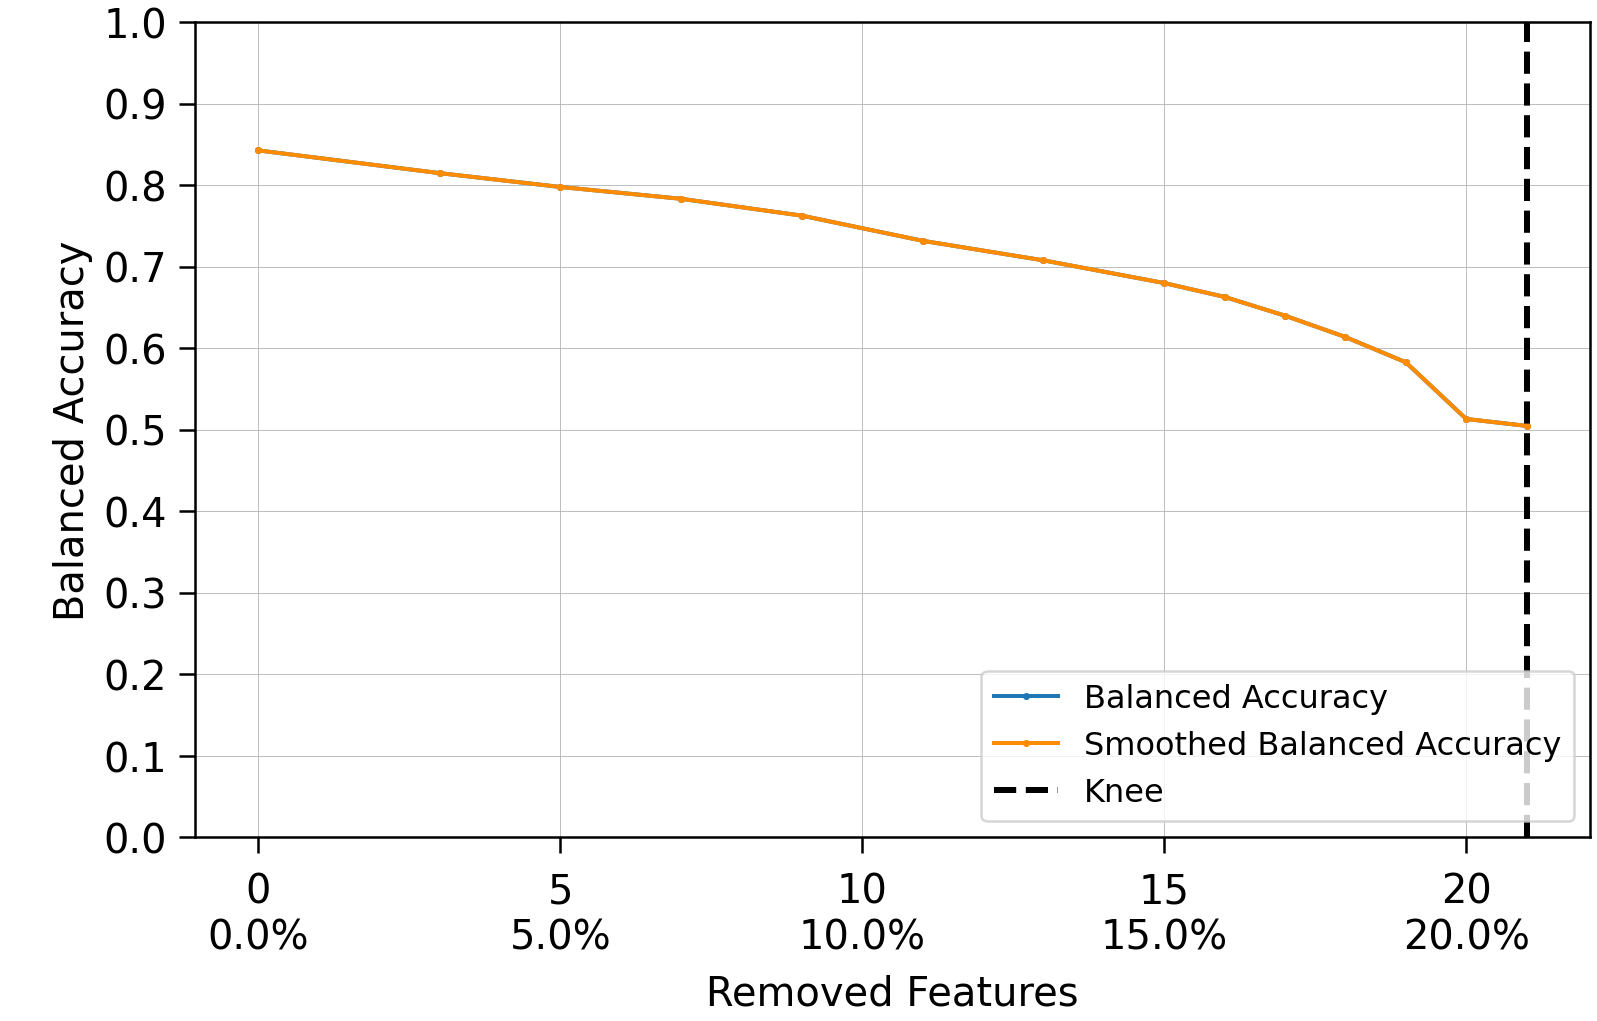

In [21]:
datafix_locate.plot_evolution()

In [22]:
mask = datafix_locate.mask_
n_corrupted_features = datafix_locate.n_corrupted_features_

print(f"{n_corrupted_features} corrupted features!")

21 corrupted features!


## DFCorrect

Next, we instantiate an object of **DFCorrect** with the specified parameters. First, we arrange the features so that the corrupted ones come first, followed by the non-corrupted ones.

In [23]:
query = np.concatenate([query[:,mask==1], query[:,mask==0]], axis=1)
reference = np.concatenate([reference[:,mask==1], reference[:,mask==0]], axis=1)

In [24]:
parameters = {
    "base_classifier" : CatBoostClassifier(verbose=False, random_state=0),
    "num_corrupted_feats" : n_corrupted_features,
    "batch_size" : 5000,
    "max_dims" : None,
    "num_epochs" : 1,
    "verbose" : False
}

In [25]:
datafix_correct = DFCorrect(**parameters)
query_corrected = datafix_correct.fit_transform(reference, query)

In [26]:
print("Finished correcting query!")

Finished correcting query!
